In [1]:
import pandas
import os
from sklearn.feature_selection import VarianceThreshold
from sklearn.cluster import DBSCAN
from sklearn.ensemble import IsolationForest, RandomForestClassifier
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.metrics import f1_score, accuracy_score, log_loss, plot_roc_curve
from sklearn.metrics import precision_recall_fscore_support as all_score
from imblearn.over_sampling import ADASYN, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.ensemble import BalancedRandomForestClassifier
from imblearn.combine import SMOTETomek
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

c:\programdata\anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
data = pandas.read_csv(os.path.abspath(os.getcwd()) + '\\mnlz\\mnlz.csv', encoding = "UTF-16LE", low_memory=False)

In [3]:
mnlz = data
mnlz = mnlz.fillna(0)
#mnlz = mnlz.loc[:, (mnlz != 0).any(axis=0)]
mnlz.shape

(32804, 568)

In [128]:
feature_names = {}
for name in list(mnlz):
    for i in range(1, 6):
        if ('Руч' + str(i)  in name or 'Ручей' + str(i) in name) and \
        'Брак' not in name and mnlz[name].dtype in ['int64', 'float64']:
            if i in feature_names.keys():
                feature_names[i].append(name)
            else:
                feature_names[i] = [name]

In [129]:
x_mnlz = mnlz.loc[:, feature_names[1]].select_dtypes(include=['int64', 'float64']).values
y_mnlz = mnlz[[f'Ручей1_Брак_загот.шт-вес']].values
for i in range(2, 6):
    y_mnlz = np.concatenate((y_mnlz, mnlz[[f'Ручей{str(i)}_Брак_загот.шт-вес']].values))
    x_mnlz = np.concatenate((x_mnlz, mnlz.loc[:, feature_names[i]].select_dtypes(include=['int64', 'float64']).values))

In [130]:
print(x_mnlz.shape, y_mnlz.shape)

(164020, 89) (164020, 1)


In [131]:
x = x_mnlz

In [132]:
#idx = np.argwhere(np.all(x_mnlz[..., :] == 0, axis=0))
#x = np.delete(x_mnlz, idx, axis=1)

In [133]:
idx = np.argwhere(np.all(y_mnlz == 0, axis=1))
x_defect = np.delete(x, idx, axis=0)
y_defect = np.delete(y_mnlz, idx, axis=0)
y_defect = np.where(y_defect != 0, 1, 0)
x_defect.shape, y_defect.shape

((1247, 89), (1247, 1))

In [134]:
idx = np.argwhere(np.all(x == 0, axis=1))
x = np.delete(x, idx, axis=0)
y = np.delete(y_mnlz, idx, axis=0)

In [135]:
x.shape, y.shape

((147385, 89), (147385, 1))

In [136]:
y = np.where(y != 0, 1, 0)
unique, counts = np.unique(y, return_counts=True)
count = dict(zip(unique, counts))
count

{0: 146138, 1: 1247}

In [137]:
number_of_trees = np.linspace(1, 100, num=11, dtype='int')

In [138]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

In [ ]:
f_scores = []
accuraciy_values = []
loss_values = []
for n in number_of_trees:
    clf = RandomForestClassifier(n_estimators=n, n_jobs=-1)
    clf.fit(X_train, y_train.ravel())
    y_predicted = clf.predict(X_test)
    f_scores.append(f1_score(y_test, y_predicted))
    accuraciy_values.append(accuracy_score(y_test, y_predicted))
    loss_values.append(log_loss(y_test, y_predicted))

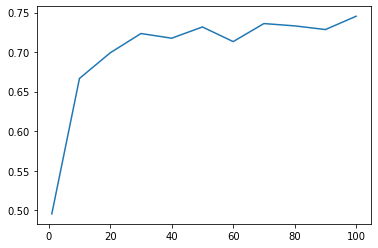

In [140]:
plt.plot(number_of_trees, f_scores)

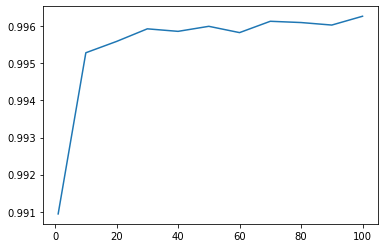

In [141]:
plt.plot(number_of_trees, accuraciy_values)

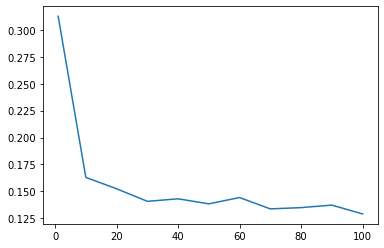

In [142]:
plt.plot(number_of_trees, loss_values)

In [143]:
X_under, y_under = RandomUnderSampler().fit_resample(X=x, y=y)
unique, counts = np.unique(y_under, return_counts=True)
count = dict(zip(unique, counts))
count

{0: 1247, 1: 1247}

In [144]:
idx = np.argwhere(y_under == 1)
x_without_defect = np.delete(X_under, idx, axis=0)
y_without_defect = np.delete(y_under, idx, axis=0)
y_without_defect = np.where(y_without_defect != 0, 1, 0)
x_without_defect.shape, y_without_defect.shape

((1247, 89), (1247,))

In [145]:
unique, counts = np.unique(y_without_defect, return_counts=True)
count = dict(zip(unique, counts))
count

{0: 1247}

In [146]:
X_train_under, X_test_under, y_train_under, y_test_under = train_test_split(X_under, y_under, test_size=0.2)

In [ ]:
f_scores_under = []
accuraciy_values_under = []
loss_values_under = []
for n in number_of_trees:
    print(n)
    clf = RandomForestClassifier(n_estimators=n, n_jobs=-1)
    clf.fit(X_train_under, y_train_under.ravel())
    y_predicted_under = clf.predict(X_test_under)
    f_scores_under.append(f1_score(y_test_under, y_predicted_under))
    accuraciy_values_under.append(accuracy_score(y_test_under, y_predicted_under))
    loss_values_under.append(log_loss(y_test_under, y_predicted_under))

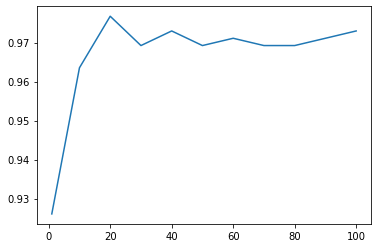

In [148]:
plt.plot(number_of_trees, f_scores_under)

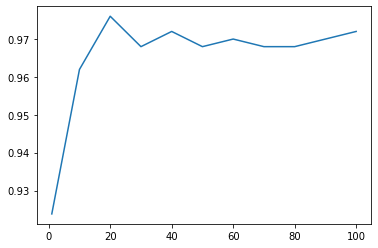

In [149]:
plt.plot(number_of_trees, accuraciy_values_under)

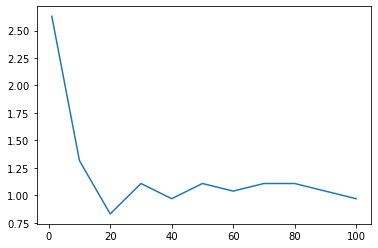

In [150]:
plt.plot(number_of_trees, loss_values_under)

In [152]:
y_predicted_under = clf.predict(x_defect)
print(f1_score(y_defect, y_predicted_under))
print(accuracy_score(y_defect, y_predicted_under))
print(all_score(y_defect, y_predicted_under))

0.9991974317817015
0.9983961507618284
(array([0., 1.]), array([0.        , 0.99839615]), array([0.        , 0.99919743]), array([   0, 1247], dtype=int64))


c:\programdata\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [153]:
y_predicted_under = clf.predict(x_without_defect)
print(f1_score(y_without_defect, y_predicted_under))
print(accuracy_score(y_without_defect, y_predicted_under))
print(all_score(y_without_defect, y_predicted_under))

0.0
0.9903769045709703
(array([1., 0.]), array([0.9903769, 0.       ]), array([0.99516519, 0.        ]), array([1247,    0], dtype=int64))


c:\programdata\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [154]:
clf.feature_importances_

array([6.15578079e-03, 6.50054898e-03, 2.67374218e-03, 2.33798045e-04,
       1.21381182e-04, 4.32608728e-02, 2.69384843e-02, 8.34579202e-04,
       3.86395719e-04, 1.05369243e-03, 3.74460258e-03, 1.11963839e-02,
       4.59204612e-03, 3.01222811e-02, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 3.79677832e-03, 5.03592445e-03, 6.49898367e-02,
       8.74014205e-03, 3.90049001e-03, 1.79365778e-01, 2.74776876e-02,
       4.27630296e-03, 1.15568702e-01, 5.96472829e-03, 4.40301650e-03,
       2.47227587e-02, 4.95165299e-03, 4.52831402e-03, 4.30707449e-03,
       9.94179220e-04, 7.07726422e-04, 7.60340273e-04, 2.46816510e-03,
       3.94541492e-03, 4.51804833e-03, 1.68406301e-02, 1.11959083e-02,
       6.74187154e-03, 9.09168917e-03, 7.15478408e-03, 6.78318180e-03,
       9.33184171e-03, 9.59196307e-03, 4.35730414e-02, 8.18304682e-03,
       6.25771462e-03, 4.89623223e-02, 9.19807899e-03, 9.66130010e-03,
       4.14742383e-02, 3.39323683e-03, 3.80355175e-03, 2.84755130e-02,
      

In [155]:
out = []
for i, imp in enumerate(clf.feature_importances_):
    if imp > 0.01:
        out.append((feature_names[1][i], imp))
sorted(out, key=lambda tup: tup[1], reverse=True)

[('Мин.знач.Скор.разл.Руч1', 0.17936577788746824),
 ('Мин.знач.Ур.в.крист.Руч1', 0.11556870185569477),
 ('Мин.значПоз.стер.стоп.Руч1', 0.06498983665628674),
 ('Мин.зн.Зон1.дав.Руч1', 0.04896232227672393),
 ('Мин.зн.Зон1.расх.Руч1', 0.043573041354038174),
 ('Ручей1-длинна_хвоста', 0.04326087280030873),
 ('Мин.зн.Зон2.расх.Руч1', 0.04147423833566503),
 ('Мин.значениеВесвпром.ковшеРуч1', 0.030122281062850895),
 ('Мин.зн.Зон2.дав.Руч1', 0.02847551299263584),
 ('Ср.знач.Ур.в.крист.Руч1', 0.027477687551825968),
 ('Ручей1-вес_хвоста', 0.026938484287276045),
 ('Мин.знач.Кач.крист.Руч1', 0.02472275866214895),
 ('Ср.знач.Де.t.кр.Руч1', 0.016840630096852074),
 ('Мин.зн.Зон3.расх.Руч1', 0.014769128467129496),
 ('Ср.значениеВесв пром.ковшеРуч1', 0.011196383891337314),
 ('Макс.знач.Де.t.кр.Руч1', 0.011195908277718498),
 ('Мин.зн.Зон3.дав.Руч1', 0.010783375488448684)]

In [156]:
mnlz.loc[mnlz['Ручей1_Брак_загот.шт-вес'] != 0, 'Ручей1_Брак_загот.шт-вес'] = 1
mnlz['Ручей1_Брак_загот.шт-вес'] = pandas.to_numeric(mnlz['Ручей1_Брак_загот.шт-вес'])
mnlz[['Ручей1_Брак_загот.шт-вес', 'Мин.знач.Скор.разл.Руч1', 'Мин.знач.Ур.в.крист.Руч1', 'Мин.зн.Зон1.расх.Руч1', 'Мин.значениеВесвпром.ковшеРуч1']].corr()

,Ручей1_Брак_загот.шт-вес,Мин.знач.Скор.разл.Руч1,Мин.знач.Ур.в.крист.Руч1,Мин.зн.Зон1.расх.Руч1,Мин.значениеВесвпром.ковшеРуч1
Ручей1_Брак_загот.шт-вес,1.000000,-0.151641,-0.266068,-0.058403,-0.088181
Мин.знач.Скор.разл.Руч1,-0.151641,1.000000,0.437115,0.938658,0.323076
Мин.знач.Ур.в.крист.Руч1,-0.266068,0.437115,1.000000,0.383804,0.528735
Мин.зн.Зон1.расх.Руч1,-0.058403,0.938658,0.383804,1.000000,0.321763
Мин.значениеВесвпром.ковшеРуч1,-0.088181,0.323076,0.528735,0.321763,1.000000


In [157]:
mnlz[['последняя_температура', 'Температура_1', 'Температура_2', 'Температура_3']].head(30)

,последняя_температура,Температура_1,Температура_2,Температура_3
0,1532.0,06:53:54 1543,06:58:00 1543,07:02:21 1534
1,1529.0,06:39:59 1549,06:56:52 1549,07:04:37 1549
2,-273.0,0,0,0
3,1531.0,08:12:16 1546,08:22:47 1541,08:32:14 1538
4,1543.0,09:15:04 1548,09:28:11 1547,09:38:31 1552
5,1546.0,10:42:00 1549,10:53:55 1549,10:54:15 1545
6,1517.0,17:24:49 1522,17:33:41 1529,17:44:33 1524
7,1519.0,16:12:15 1525,16:22:57 1525,16:23:13 1528
8,1511.0,13:50:13 1511,14:01:50 1511,14:13:12 1521
9,1509.0,15:07:57 1517,15:14:48 1517,15:15:14 1523


In [4]:
df = pandas.DataFrame()
df[['time1', 'temp1']] = mnlz['Температура_1'].str.split(expand=True)
df[['time2', 'temp2']] = mnlz['Температура_2'].str.split(expand=True)
df[['time3', 'temp3']] = mnlz['Температура_3'].str.split(expand=True)
df['last_temp'] = mnlz['последняя_температура']
df = df.fillna(0)

In [5]:
df[['temp1', 'temp2', 'temp3']] =  df[['temp1', 'temp2', 'temp3']].astype('float64')

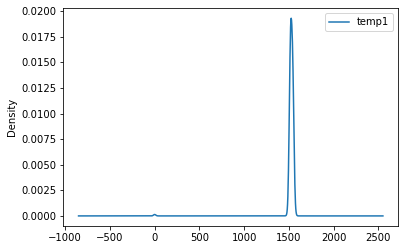

In [6]:
df[['temp1']].plot.kde()

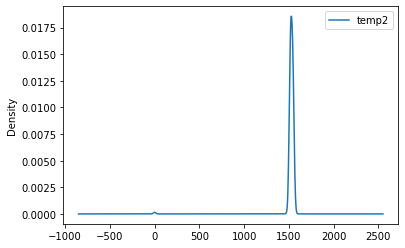

In [7]:
df[['temp2']].plot.kde()

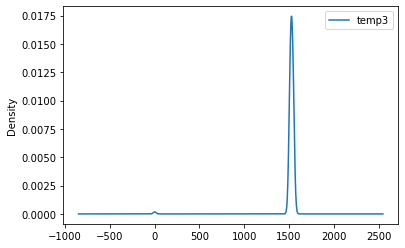

In [8]:
df[['temp3']].plot.kde()

In [9]:
print(df.shape)
df = df.drop(df[df['time1'] == 0].index)
df = df.drop(df[df['time2'] == 0].index)
df = df.drop(df[df['time3'] == 0].index)
print(df.shape)

(32804, 7)
(32553, 7)


In [10]:
df['time1'] = pandas.to_datetime(df['time1'], format='%H:%M:%S')
df['time2'] = pandas.to_datetime(df['time2'], format='%H:%M:%S')
df['time3'] = pandas.to_datetime(df['time3'], format='%H:%M:%S')
print(df['time1'])

0       1900-01-01 06:53:54
1       1900-01-01 06:39:59
3       1900-01-01 08:12:16
4       1900-01-01 09:15:04
5       1900-01-01 10:42:00
                ...        
32799   1900-01-01 04:08:02
32800   1900-01-01 05:04:46
32801   1900-01-01 06:03:35
32802   1900-01-01 06:51:02
32803   1900-01-01 07:37:00
Name: time1, Length: 32553, dtype: datetime64[ns]


In [11]:
from datetime import datetime

In [12]:
df_temp1 = df[['time1', 'temp1']].groupby("time1").mean()
df_temp2 = df[['time2', 'temp2']].groupby("time2").mean()
df_temp3 = df[['time3', 'temp3']].groupby("time3").mean()

In [13]:
temp1_values = df_temp1['temp1'].values
time1_values = df_temp1.index.values

temp2_values = df_temp2['temp2'].values
time2_values = df_temp2.index.values

temp3_values = df_temp3['temp3'].values
time3_values = df_temp3.index.values

In [14]:
time1_values

array(['1900-01-01T00:00:00.000000000', '1900-01-01T00:00:02.000000000',
       '1900-01-01T00:00:06.000000000', ...,
       '1900-01-01T23:59:22.000000000', '1900-01-01T23:59:52.000000000',
       '1900-01-01T23:59:54.000000000'], dtype='datetime64[ns]')

In [15]:
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
import matplotlib.dates as md

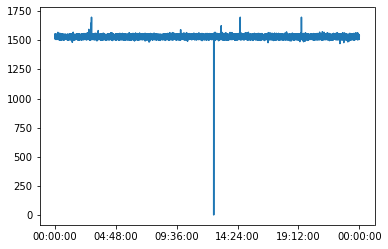

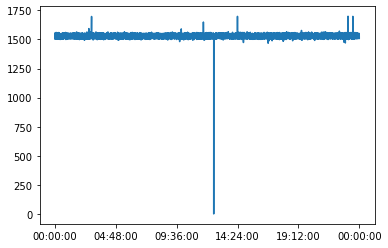

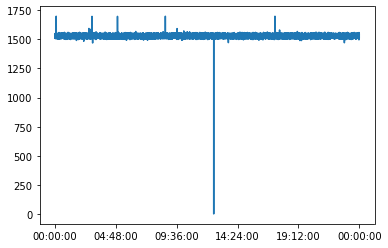

In [16]:
import matplotlib.dates as md

datenums1=md.date2num(time1_values)
ax=plt.gca()
xfmt = md.DateFormatter('%H:%M:%S')
ax.xaxis.set_major_formatter(xfmt)
plt.plot(datenums1, temp1_values)
plt.show()

datenums2=md.date2num(time2_values)
ax=plt.gca()
xfmt = md.DateFormatter('%H:%M:%S')
ax.xaxis.set_major_formatter(xfmt)
plt.plot(datenums2, temp2_values)
plt.show()

datenums3=md.date2num(time3_values)
ax=plt.gca()
xfmt = md.DateFormatter('%H:%M:%S')
ax.xaxis.set_major_formatter(xfmt)
plt.plot(datenums3, temp3_values)
plt.show()

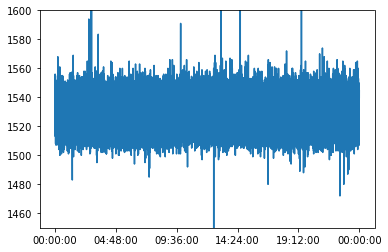

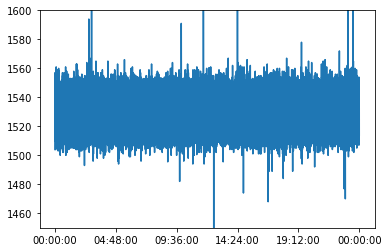

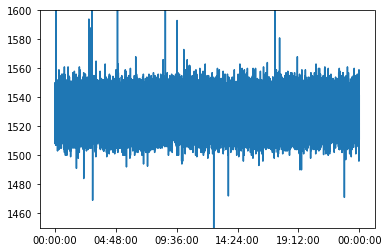

In [17]:
ax=plt.gca()
xfmt = md.DateFormatter('%H:%M:%S')
ax.xaxis.set_major_formatter(xfmt)
plt.plot(datenums1, temp1_values)
plt.ylim(1450, 1600)
plt.show()

ax=plt.gca()
xfmt = md.DateFormatter('%H:%M:%S')
ax.xaxis.set_major_formatter(xfmt)
plt.plot(datenums2, temp2_values)
plt.ylim(1450, 1600)
plt.show()

ax=plt.gca()
xfmt = md.DateFormatter('%H:%M:%S')
ax.xaxis.set_major_formatter(xfmt)
plt.plot(datenums3, temp3_values)
plt.ylim(1450, 1600)
plt.show()


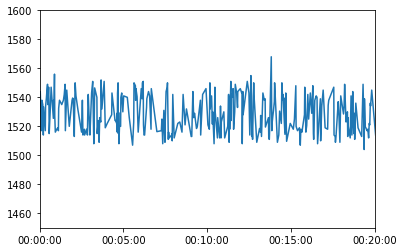

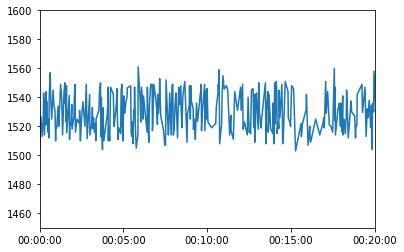

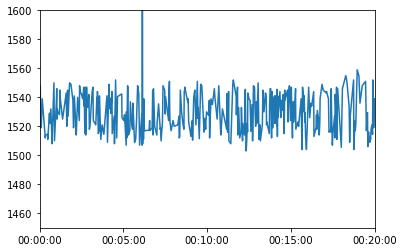

In [18]:
ax=plt.gca()
xfmt = md.DateFormatter('%H:%M:%S')
ax.xaxis.set_major_formatter(xfmt)
plt.plot(datenums1, temp1_values)
start_time = datetime(1900, 1, 1, 0, 0, 0)
end_time = datetime(1900, 1, 1, 0, 20, 0)
plt.xlim(start_time, end_time)
plt.ylim(1450, 1600)
plt.show()

ax=plt.gca()
xfmt = md.DateFormatter('%H:%M:%S')
ax.xaxis.set_major_formatter(xfmt)
plt.plot(datenums2, temp2_values)
start_time = datetime(1900, 1, 1, 0, 0, 0)
end_time = datetime(1900, 1, 1, 0, 20, 0)
plt.xlim(start_time, end_time)
plt.ylim(1450, 1600)
plt.show()

ax=plt.gca()
xfmt = md.DateFormatter('%H:%M:%S')
ax.xaxis.set_major_formatter(xfmt)
plt.plot(datenums3, temp3_values)
start_time = datetime(1900, 1, 1, 0, 0, 0)
end_time = datetime(1900, 1, 1, 0, 20, 0)
plt.xlim(start_time, end_time)
plt.ylim(1450, 1600)
plt.show()

In [40]:
z = np.abs(stats.zscore(df[['temp1', 'temp2', 'temp3', 'last_temp']]))
outliers = pandas.DataFrame(columns=list(df))
out_rows = pandas.DataFrame(columns=list(mnlz))
for i in np.argwhere(z>1):
    if 0 not in df.loc[[i[0]]].values:
        outliers = pandas.concat([outliers, df.loc[[i[0]]] ])
        out_rows = pandas.concat([out_rows, mnlz.loc[[i[0]]] ])
outliers

,time1,temp1,time2,temp2,time3,temp3,last_temp
876,04:14:57,1546.0,04:32:20,1546.0,04:56:00,1698.0,1550.00000
2309,02:51:33,1649.0,02:54:19,1546.0,03:04:56,1536.0,1544.00000
2844,19:26:15,1698.0,19:26:30,1578.0,19:29:46,1512.0,1508.00000
5260,02:48:51,1529.0,03:03:51,1529.0,03:11:52,1526.0,-273.00000
6645,02:10:30,1532.0,02:12:21,1532.0,02:13:01,1548.0,1649.00000
6646,03:24:54,1649.0,03:25:14,1532.0,03:31:00,1544.0,1538.00000
9816,02:53:07,1698.0,02:53:22,1698.0,02:55:28,1698.0,1508.00000
9816,02:53:07,1698.0,02:53:22,1698.0,02:55:28,1698.0,1508.00000
9816,02:53:07,1698.0,02:53:22,1698.0,02:55:28,1698.0,1508.00000
10360,23:59:22,1537.0,00:05:38,1542.0,00:06:08,1699.0,1540.00000


In [ ]:
pandas.set_option('display.max_columns', 500)
pandas.set_option('display.max_rows', 8)
out_rows

In [ ]:
x_stnd = StandardScaler().fit_transform(x)
x_stnd.shape

In [ ]:
pca = PCA(40)
principalComponents = pca.fit_transform(x_stnd)

In [ ]:
pca.explained_variance_ratio_.cumsum()

In [ ]:
plt.hist(principalComponents[:,0], color = 'blue', edgecolor = 'black',bins = int(180/5))
plt.show()

In [ ]:
sns.heatmap(pca.get_covariance())

In [ ]:
z = np.abs(stats.zscore(principalComponents))
print(len(np.where(z > 10)[0]))
print(z.shape)

In [ ]:
new_feature_names = {}
for name in list(mnlz):
    for i in range(1, 6):
        if ('Руч' + str(i)  in name or 'Ручей' + str(i) in name) :
            if i in new_feature_names.keys():
                new_feature_names[i].append(name)
            else:
                new_feature_names[i] = [name]

In [ ]:
new_mnlz = mnlz.loc[:, new_feature_names[1]]
for i in range(2, 6):
    new_mnlz = pandas.concat([new_mnlz, mnlz.loc[:, new_feature_names[1]]])

In [ ]:
for column_name in new_mnlz.select_dtypes(include=['int64', 'float64']):
    print(column_name)
    print(new_mnlz[column_name].max())
    print(new_mnlz[column_name].min())

In [ ]:
feature_names = {}
for name in list(mnlz):
    for i in range(1, 6):
        if ('Руч' + str(i)  in name or 'Ручей' + str(i) in name):
            if i in feature_names.keys():
                feature_names[i].append(name)
            else:
                feature_names[i] = [name]
first = mnlz.loc[:, feature_names[1]]
first.loc[first['Ручей1_Брак_загот.шт-вес'] != 0, 'Ручей1_Брак_загот.шт-вес'] = 1
first['Ручей1_Брак_загот.шт-вес'] = pandas.to_numeric(first['Ручей1_Брак_загот.шт-вес'])
correlation_matrix = first.corr()
with pandas.option_context('display.max_rows', None, 'display.max_columns', None):
    print(correlation_matrix['Ручей1_Брак_загот.шт-вес'])

In [ ]:
selector = VarianceThreshold(0.5)
selector.fit(mnlz.select_dtypes(include=['int64', 'float64']))
new_mnlz = mnlz[mnlz.columns[selector.get_support(indices=True)]]

In [ ]:
clf = IsolationForest( behaviour = 'new', max_samples=32804, contamination= 'auto')
preds = clf.fit_predict(mnlz.select_dtypes(include=['int64', 'float64']))

In [ ]:
list(preds).count(-1)

In [40]:
data = pandas.read_csv(os.path.abspath(os.getcwd()) + '\\mnlz\\mnlz_temperatures.csv', encoding = "UTF-16LE", low_memory=False)
mnlz_temperatures = data
mnlz_temperatures = mnlz_temperatures.fillna(0)
mnlz_temperatures = mnlz_temperatures.loc[:, (mnlz_temperatures != 0).any(axis=0)]

In [45]:
mnlz_temperatures.head(10)

,AREA_ID,HEAT_ID,MEASURE_DATE,MEASURE_NO,ROUND(T.TEMPERATURE-273),TEMPERATURE,Unnamed: 0,VISIT_NO
0,CCM 2,6F6481,2016-10-06 06:58:00,2,1543,1816.0,0.0,1
1,CCM 2,6F6481,2016-10-06 06:53:54,1,1543,1816.0,0.0,1
2,CCM 2,6F6481,2016-10-06 07:02:21,3,1534,1807.0,0.0,1
3,CCM 2,6F6481,2016-10-06 07:14:38,5,1544,1817.0,0.0,1
4,CCM 2,6F6481,2016-10-06 07:03:06,4,1547,1820.0,0.0,1
5,CCM 2,6F6481,2016-10-06 07:48:50,9,1534,1807.0,0.0,1
6,CCM 2,6F6481,2016-10-06 07:54:31,10,1532,1805.0,0.0,1
7,CCM 2,6F6481,2016-10-06 07:40:53,8,1537,1810.0,0.0,1
8,CCM 2,6F6481,2016-10-06 07:24:00,6,1544,1817.0,0.0,1
9,CCM 2,6F6481,2016-10-06 07:31:41,7,1541,1814.0,0.0,1


(210328, 8)

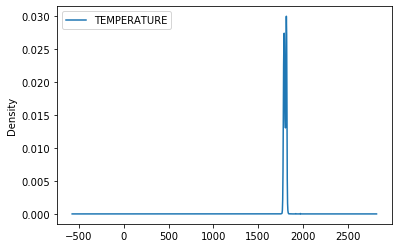

In [46]:
mnlz_temperatures[['TEMPERATURE']].plot.kde()
mnlz_temperatures.shape